In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder, RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV,RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error, make_scorer, mean_absolute_percentage_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn import set_config; set_config(display='diagram')
#import geopandas as gpd

%load_ext autoreload
%autoreload 2

In [2]:
from data_cleaning import clean_data

In [10]:
data = pd.read_csv('housing_data_full.csv',low_memory=False)
data.shape

(33991, 43)

In [14]:
data = data.drop_duplicates()

In [15]:
data.shape

(29560, 32)

In [13]:
data = clean_data(data)

In [9]:
data.corr()['Price'].sort_values(ascending=False)

Price                         1.000000
Size                          0.866559
N_Bedrooms                    0.779276
N_Bathrooms                   0.751795
Pool                          0.476713
Fitness Centers               0.474869
Floor Heating                 0.466654
Playground                    0.464090
Parking                       0.400825
Tennis Courts                 0.386200
Floor                         0.357330
Oven                          0.320996
Balcony                       0.320583
Recently renovated            0.265560
Air Filter                    0.253996
Water Filter                  0.253594
English Speaking Landlord     0.237800
Large Storage Room            0.223562
Pets_allowed                  0.187196
Garden                        0.180911
Longtitude                    0.151488
Wall heating                  0.136587
Listing_Id                    0.032826
Latitude                      0.005375
Landlord lives in Shanghai   -0.015235
Historic Building        

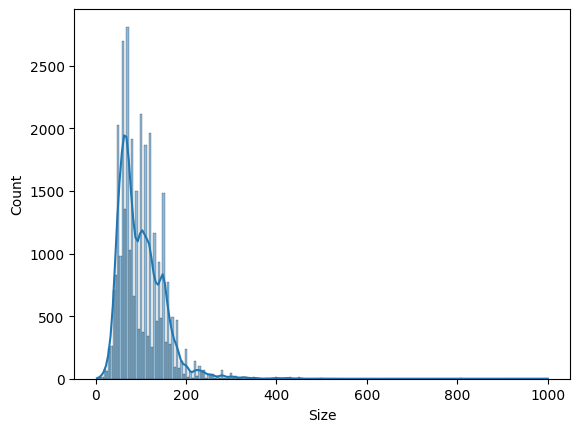

In [10]:
import seaborn as sns
sns.histplot(data['Size'], bins=200,kde = True);

In [19]:
data[data['Size'] > 300]['Price'].sort_values()

11038     8000.0
17838     8000.0
29380    28000.0
28591    28999.0
6377     29000.0
          ...   
86       59000.0
27474    59800.0
27956    60000.0
9180     60000.0
25859        NaN
Name: Price, Length: 140, dtype: float64

In [18]:
data.iloc[25859]

Listing_Id                              1561548.0
Price                                     10500.0
Size                                           55
N_Bedrooms                                    1.0
N_Bathrooms                                   1.0
Available From                2023-10-16 00:00:00
Floor                                        19.0
Furnished                               Furnished
District                                  Jing'an
Metro                                Changping Rd
Latitude                                 31.23012
Longtitude                             121.437408
First_post                             2023-10-16
Balcony                                       0.0
Landlord lives in Shanghai                    1.0
Oven                                          1.0
Recently renovated                            NaN
Air Filter                                    1.0
English Speaking Landlord                     0.0
Fitness Centers                               0.0


In [13]:
data = data.drop(index=[11038,17838,25859])

In [17]:
data = data.drop(columns='Yoga Facilities')

In [18]:
data.shape

(32807, 31)

In [19]:
data = data.reset_index(drop=True)

#This is to draw the geometry map

downtown = gpd.read_file('sh-towns.geojson')

data = gpd.GeoDataFrame(data=data, geometry=gpd.points_from_xy(data.Longtitude,data.Latitude))

ax = downtown['geometry'].plot(figsize=(10,10), color='none', edgecolor='gainsboro', zorder=3);

data['geometry'].plot(markersize=1,ax=ax)

ax.set_xlim((121,121.8))

ax.set_ylim((31,31.5))

# Feature Engineering

In [20]:
y = data['Price']
X = data.drop(columns=['Price','Available From','First_post'])

In [16]:
oe = OrdinalEncoder(categories=[['Unfurnished','Furnished']])
oe_fs = data[['Furnished']]
data['Furnished'] = oe.fit_transform(oe_fs)

In [25]:
ohe = OneHotEncoder(handle_unknown='ignore')
#ohe_fs = data[['Metro','District']]
ohe.fit(data[['Metro','District']])
data[ohe.get_feature_names_out()] = ohe.transform(data[['Metro','District']])

ValueError: Columns must be same length as key

In [19]:
ohe.fit(ohe_fs)

OneHotEncoder(handle_unknown='ignore')

In [57]:
data[ohe.get_feature_names_out()] = ohe.transform(ohe_fs)

ValueError: Columns must be same length as key

In [58]:
ohe.get_feature_names_out().shape

(224,)

In [59]:
transformed_data.shape

(31344, 224)

In [62]:
ohe.transform(ohe_fs)

<31344x224 sparse matrix of type '<class 'numpy.float64'>'
	with 62688 stored elements in Compressed Sparse Row format>

In [28]:
ohe.transform(data[['Metro','District']]).shape

(32807, 226)

In [26]:
ohe.get_feature_names_out().shape

(226,)

In [29]:
data.shape

(32807, 31)

In [20]:
num_transformer = Pipeline([
    ('standard_scaler', StandardScaler())
])

oe_transformer = OrdinalEncoder(categories=[['Unfurnished','Furnished']])

ohe_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('oe_transformer', oe_transformer, ['Furnished']),
    ('ohe_transformer', ohe_transformer,['Metro','District']),
    ('num_transformer', num_transformer,X.select_dtypes(include='number').columns)],
    remainder='passthrough'
)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('oe_transformer',
                                 OrdinalEncoder(categories=[['Unfurnished',
                                                             'Furnished']]),
                                 ['Furnished']),
                                ('ohe_transformer',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Metro', 'District']),
                                ('num_transformer',
                                 Pipeline(steps=[('standard_scaler',
                                                  StandardScaler())]),
                                 Index(['Listing_Id', 'Size', 'N_Bedrooms', 'N_Bathrooms', 'Floor', 'Latitude',
       'Longtitude', 'Balcony', 'Landlord lives in Shanghai', 'Oven',
       'Recently renovated', 'Air Filter', 'English Speaking Landlord',
       'Fitness Centers', 'Floor Heating', 'Garden', 'Historic Building',
       'Large Storage Room', 'Parking', 'Playground', 'Pool', 'Tennis Courts',
       'Wall heating', 'Water Filter', 'Pets_allowed'],
      dtype='object'))])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [22]:
X_train_new = preprocessor.fit_transform(X_train)

In [23]:
X_test_new = preprocessor.transform(X_test)

In [24]:
rmse = make_scorer(mean_squared_log_error,greater_is_better=True, squared = False)

# Base Models

In [25]:
base_model = DecisionTreeRegressor()
results = cross_validate(base_model, X_train_new, y_train, cv=5, scoring=rmse)
results['test_score'].mean()

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jessica/.pyenv/versions/3.10.6/envs/JC/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jessica/.pyenv/versions/3.10.6/envs/JC/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 1342, in fit
    super().fit(
  File "/home/jessica/.pyenv/versions/3.10.6/envs/JC/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 172, in fit
    X, y = self._validate_data(
  File "/home/jessica/.pyenv/versions/3.10.6/envs/JC/lib/python3.10/site-packages/sklearn/base.py", line 591, in _validate_data
    X = check_array(X, input_name="X", **check_X_params)
  File "/home/jessica/.pyenv/versions/3.10.6/envs/JC/lib/python3.10/site-packages/sklearn/utils/validation.py", line 822, in check_array
    array = _ensure_sparse_format(
  File "/home/jessica/.pyenv/versions/3.10.6/envs/JC/lib/python3.10/site-packages/sklearn/utils/validation.py", line 551, in _ensure_sparse_format
    _assert_all_finite(
  File "/home/jessica/.pyenv/versions/3.10.6/envs/JC/lib/python3.10/site-packages/sklearn/utils/validation.py", line 146, in _assert_all_finite
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
DecisionTreeRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [71]:
base_model.fit(X_train_new, y_train)

DecisionTreeRegressor()

In [72]:
y_base = base_model.predict(X_test_new)
mean_absolute_error(y_test,y_base)

1530.077422066294

In [18]:
model_RFR = RandomForestRegressor()
results = cross_validate(model_RFR, X_train_new, y_train, cv=5, scoring=rmse)
results['test_score'].mean()

0.13964284410908512

In [19]:
model_RFR.fit(X_train_new, y_train)

RandomForestRegressor()

In [20]:
y_RFR = model_RFR.predict(X_test_new)
mean_absolute_error(y_test,y_RFR)

1364.4092781205463

In [21]:
model_XGB = XGBRegressor(n_estimators=100,
                         max_depth=4,
                        learning_rate=0.1)
results = cross_validate(model_XGB, X_train_new, y_train, cv=5, scoring=rmse)
results['test_score'].mean()

0.17210739127288283

In [22]:
model_XGB.fit(X_train_new, y_train)
y_pred = model_XGB.predict(X_test_new)

In [23]:
mean_absolute_error(y_test,y_pred)

2086.1630322877695

In [77]:
model_tuning = RandomForestRegressor()

grid = {
    'n_estimators': [100,150,200], 
    'max_depth': [7, 10, 15],
    'learning_rate': [0.01, 0.02]
}

search = RandomizedSearchCV(
    model_XGB,
    grid, 
    scoring = rmse,
    cv = 5,
    n_jobs=-1
) 

search.fit(X_train_new, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=0, gpu_id=-1,
                                          grow_policy='depthwise',
                                          importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.1, max_bin=256,
                                          max_cat_t...
                                          max_depth=4, max_leaves=0,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=0,
                                          num_parallel_tree=1, predictor='auto',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.02, 0.001],
                                        'max_depth': [7, 10, 15],
                                        'n_estimators': [100, 150, 200]},
                   scoring=make_scorer(mean_squared_log_error, squared=False))

In [84]:
search.best_params_

{'n_estimators': 150, 'max_depth': 15, 'learning_rate': 0.001}

In [78]:
search.best_score_

1.9695969556441715

In [79]:
model=search.best_estimator_

In [80]:
y_pred = model.predict(X_test_new)

In [81]:
mean_absolute_error(y_test,y_pred)

13670.808474704352

In [82]:
y_pred

array([2668.069 , 4792.544 , 4309.6104, ..., 3691.6658, 3447.169 ,
       1118.6322], dtype=float32)

In [83]:
y_test

15150    22800
2769     32000
5624     22000
20165     6300
20753    27000
         ...  
9966      8200
6168      5000
12439    20800
10972    24000
1312      7500
Name: Price, Length: 6871, dtype: int32

# Try only 10 columns 

In [ ]:
oe_features = ['Furnished']
oe = OrdinalEncoder(categories=[['Unfurnished', 'Furnished']],handle_unknown='error')
data['Furnished'] = oe.fit_transform(data[oe_features])

In [ ]:
ohe_feature = ['Metro','District']
ohe = OneHotEncoder(handle_unknown='error',sparse=False)
ohe.fit(data[ohe_feature])
ohe_new = pd.DataFrame(ohe.transform(data[ohe_feature]),
         columns=ohe.get_feature_names_out())
data.drop(columns=ohe_feature, inplace=True)
data = pd.concat([data,ohe_new],axis=1,join='inner')

In [47]:
data.corr()['Price'].sort_values(ascending=False)[1:31]

Size                         0.865318
N_Bedrooms                   0.777417
N_Bathrooms                  0.748154
Pool                         0.492255
Fitness Centers              0.487969
Playground                   0.481926
Floor Heating                0.461390
Tennis Courts                0.409063
Parking                      0.405901
Floor                        0.358734
Oven                         0.325565
Balcony                      0.318123
Air Filter                   0.271002
Recently renovated           0.263364
English Speaking Landlord    0.254386
Water Filter                 0.247372
Large Storage Room           0.228751
Pets_allowed                 0.210268
Garden                       0.180584
Longtitude                   0.169995
District_Pudong              0.151676
Metro_Shangcheng Rd          0.146712
Wall heating                 0.144796
Metro_Lujiazui               0.106178
Metro_Lantian Road           0.086597
Metro_Xintiandi              0.081667
Metro_Laoxim

In [10]:
data.columns

Index(['Price', 'Size', 'N_Bedrooms', 'N_Bathrooms', 'Available From', 'Floor',
       'Furnished', 'District', 'Metro', 'Latitude', 'Longtitude',
       'First_post', 'Balcony', 'Landlord lives in Shanghai', 'Oven',
       'Recently renovated', 'Air Filter', 'English Speaking Landlord',
       'Fitness Centers', 'Floor Heating', 'Garden', 'Historic Building',
       'Large Storage Room', 'Parking', 'Playground', 'Pool', 'Tennis Courts',
       'Wall heating', 'Water Filter', 'Pets_allowed'],
      dtype='object')

In [48]:
#Taking only the top 10 to train
top_10_features = data.corr()['Price'].sort_values(ascending=False)[1:31].index.tolist()

In [49]:
top_10_features

['Size',
 'N_Bedrooms',
 'N_Bathrooms',
 'Pool',
 'Fitness Centers',
 'Playground',
 'Floor Heating',
 'Tennis Courts',
 'Parking',
 'Floor',
 'Oven',
 'Balcony',
 'Air Filter',
 'Recently renovated',
 'English Speaking Landlord',
 'Water Filter',
 'Large Storage Room',
 'Pets_allowed',
 'Garden',
 'Longtitude',
 'District_Pudong',
 'Metro_Shangcheng Rd',
 'Wall heating',
 'Metro_Lujiazui',
 'Metro_Lantian Road',
 'Metro_Xintiandi',
 'Metro_Laoximen',
 'Metro_Panlong Rd',
 'Metro_Fangdian Rd',
 'Metro_West Nanjing Rd']

In [50]:
X = data[top_10_features]
y = data['Price']

In [51]:
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X, y, test_size=0.3)

In [52]:
scalar = MinMaxScaler()
X_train_10_new, X_test_10_new = scalar.fit_transform(X_train_10), scalar.transform(X_test_10)

In [53]:
model_DTR = DecisionTreeRegressor()
results = cross_validate(model_DTR, X_train_10_new, y_train_10, cv=5, scoring=rmse)
results['test_score'].mean()

0.19513057678874385

/root/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.6459091966150202

In [57]:
model_DTR.fit(X_train_10_new, y_train_10)
y_DTR = model_DTR.predict(X_test_10_new)
mean_absolute_error(y_test_10,y_DTR)

1618.3758380913025